<a href="https://colab.research.google.com/github/RaoSiddhant/SIT796_RL/blob/main/Task_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Importing Relevant Packages
import sys
import gym
from gym import envs
import numpy as np
import random
from collections import defaultdict
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

#Assigning the Blackjack gym environment to a variable
env = gym.make('Blackjack-v0')

#FIRST WE CREATE FUNCTIONS FOR THE PLOTS WE SHOW FOR BOTH CASES

#We start by creating the functions for 3-D plot to show State-Values with Dealer's Showing Card and Player's Current Sum
#This Plot is shown for both on and off policies later
def plot_blackjack_values(V, title):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('{} (Usable Ace)'.format(title))
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('{} (No Usable Ace)'.format(title))
    get_figure(False, ax)
    plt.show()

#Next we create a fuction to show plots for policy. Each plot shows if the player hits pr sticks
#for each dealer showing card and player current sum for usable ace and no-usable ace cases
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

#In Monte Carlo On and Off Policy for Blackjack, we have Returns instead of Rewards so we will talk in terms of returns now
#Function to show plots of Actual Returns and Cumulative Returns for each Episode or Trial in our case
def returns_vs_eps_plot(n_episodes,Q,title):
  nA=env.action_space.n
  act_ret=[]
  cumu_ret=[]
  cumu_return=0
  for i_episode in range(n_episodes):
    state = env.reset()
    act_return=0
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], 0, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        state = next_state
        if done:
            if reward>0:
              act_return=act_return+1
              cumu_return=cumu_return+1
            else:
              act_return=act_return-1
              cumu_return=cumu_return-1
            act_ret.append(act_return)
            cumu_ret.append(cumu_return)
            break

  plt.plot(act_ret)
  plt.xlabel('Episodes')
  plt.ylabel('Return at each Episode Trial')
  plt.title('Actual Return vs Episode Trial for {} Monte Carlo Learning for Blackjack'.format(title))
  plt.show()

  plt.plot(cumu_ret)
  plt.xlabel('Episodes')
  plt.ylabel('Cumulative Return')
  plt.title('Cumulative Return vs Episode Trial for {} Monte Carlo Learning for Blackjack'.format(title))
  plt.show()



Episode 500000/500000.

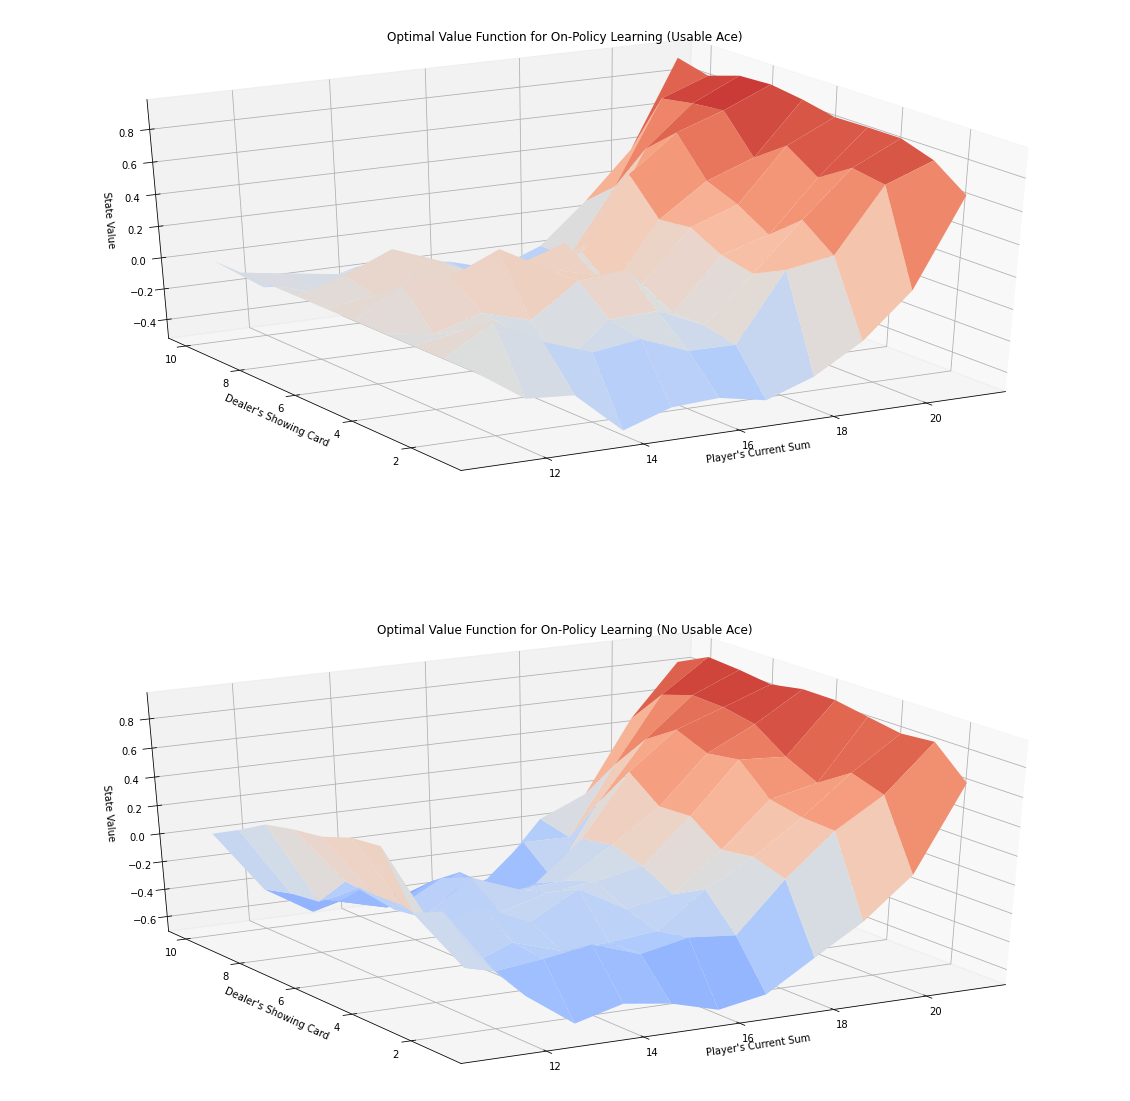

In [3]:
#FOR ON-POLICY
#We consider the greedy case for comparison and show its results here as well

def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # obtains the action probabilities corresponding to epsilon-greedy policy
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s
  
''' 
Now we will use this get_probs func in generating the episode. 
Note that we are no longer using the stochastic policy we started with, instead building upon it in an epsilon greedy way.
'''
def generate_episode_from_Q(env, Q, epsilon, nA):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

''' 
Finally Q values are approximated by taking average of corresponding returns.
But instead we can write it using incremental mean and constant alpha.
As we are using constant alpha we need not keep a track of N-table, ie how many times we visited that state.
''' 

def update_Q(env, episode, Q, alpha, gamma):
    # updates the action-value function estimate using the most recent episode 
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.015)

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V, title="Optimal Value Function for On-Policy Learning")


On-Policy MC Learning Policy:


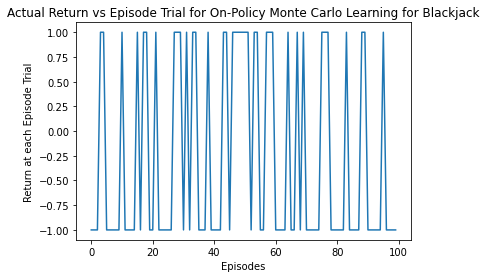

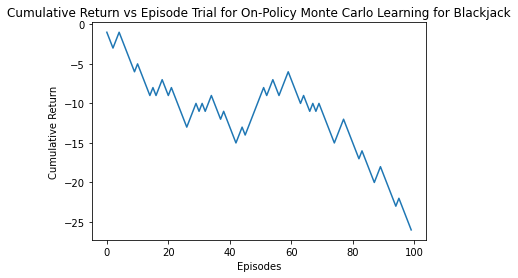

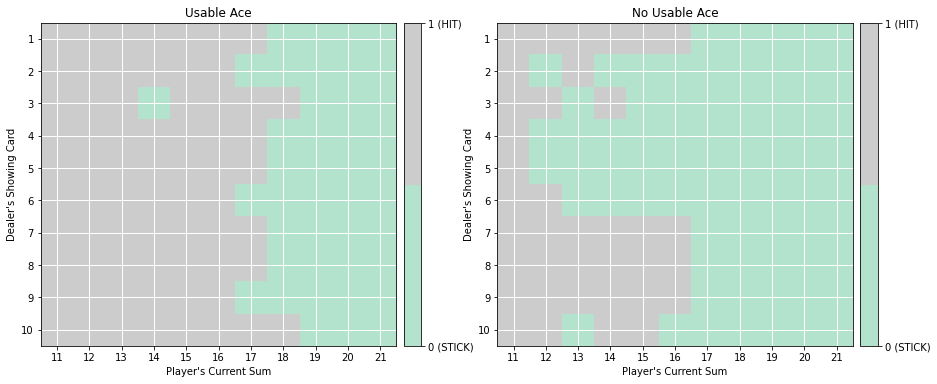

In [4]:
#FOR ON-POLICY
print("On-Policy MC Learning Policy:")
#Return and Cumulative Returns vs Episodes plots
n_episodes=100
returns_vs_eps_plot(n_episodes,Q,title='On-Policy')

#Policy Plots
plot_policy(policy)

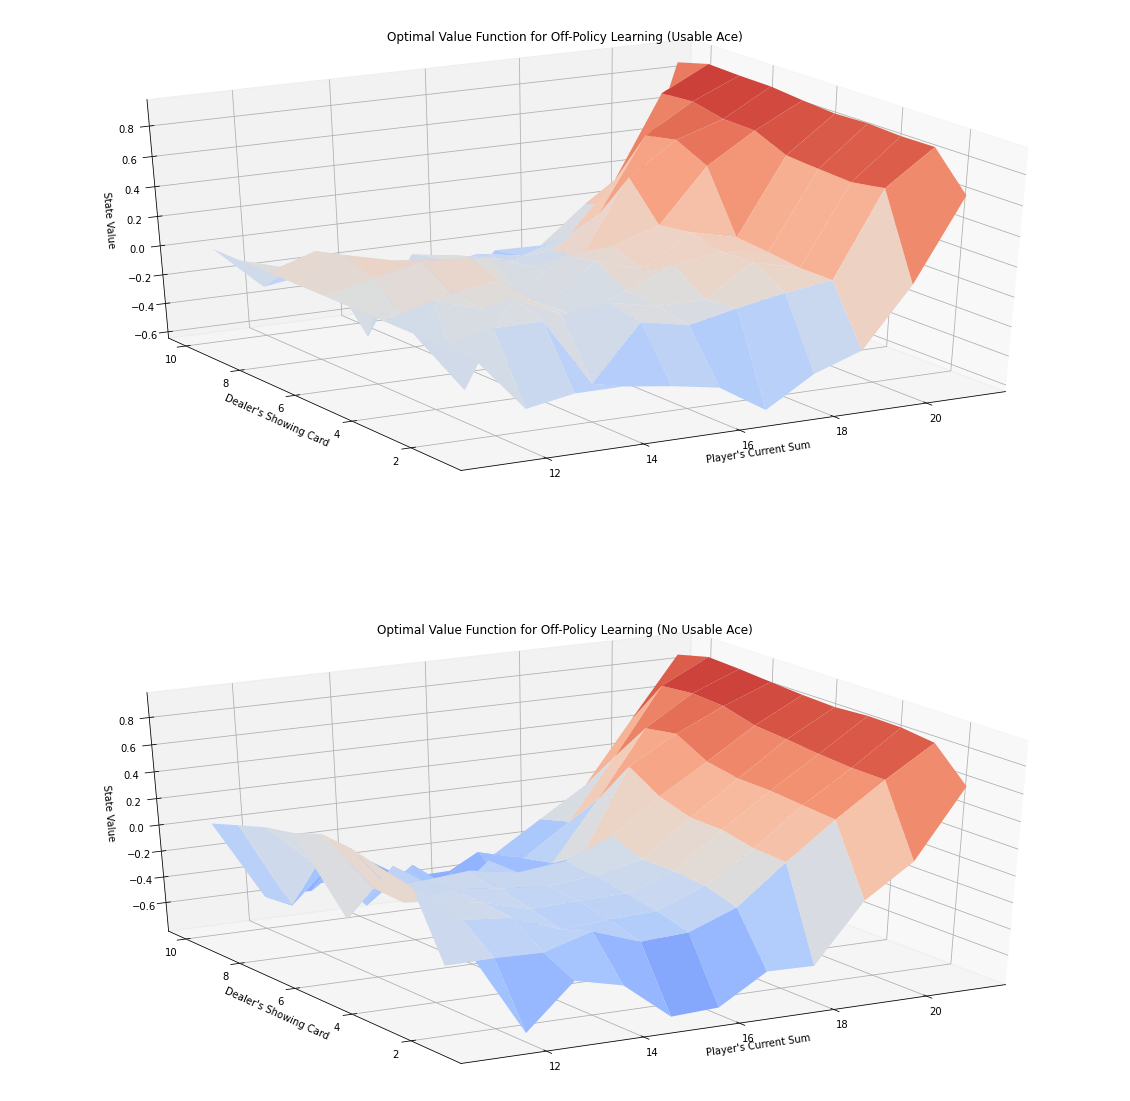

In [5]:
#FOR OFF-POLICY
#We compare the Target Policy with the Behaviour Policy to evaluate and improve the optimal policy
#This comparison is done in the 'Off_pol_mc_control_learn' function
#The current optimal policy being learnt is the target policy and is stored as target_policy
#It returns the optimal target policy as the output 

#Creates a random policy function, taking number of actions in the environment as argument
#It returns a function that takes an observation state as input and returns a vector of action probabilities 
def create_random_policy(nA):

    A = np.ones(nA, dtype=float) / nA
    def policy_fn(obs):
        return A
    return policy_fn

#Creates greedy action policy, taking environment and Q table as arguments and returns greedy action policy function
def create_greedy_action_policy(env,Q):

    def policy(obs):
        P = np.zeros_like(Q[obs], dtype=float)
        best_action = np.argmax(Q[obs])  #get best action
        P[best_action] = 1
        return P
    return policy


#We apply Monte Carlo Off-Policy Control here. We use weighted importance sampling to find an optimal greedy policy
#Takes our environment, number of episodes to sample, policy to follow while generating episodes and gamma discount factor as arguments
#Returns a tuple with Q-dictionary mapping state-action values, the optimal greedy policy and G-Rewards
def Off_pol_mc_control_learn(env, num_episodes, policy, discount_factor):
   
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedy policy 
    target_policy = create_greedy_action_policy(env,Q)
        
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            clear_output(wait=True)

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            # Sample an action from our policy
            probs = target_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = discount_factor * G + reward
            #print(G)
            # Update weighted importance sampling formula denominator
            C[state][action] += W
            # Update the action-value function using the incremental update formula 
            # This also improves our target policy which holds a reference to Q
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # If the action taken by the policy is not the action 
            # taken by the target policy the probability will be 0 and we can break
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./policy(state)[action]
        
    return Q, target_policy,G


env = gym.make('Blackjack-v0')
env.reset()
rand = create_random_policy(env.action_space.n)
Q_off_Pol,off_MC_Learned_Policy,Reward = Off_pol_mc_control_learn(env, 500000, rand,0.9)

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q_off_Pol.items())

# plot the state-value function
plot_blackjack_values(V, title="Optimal Value Function for Off-Policy Learning")


Off-Policy MC Learning Policy:


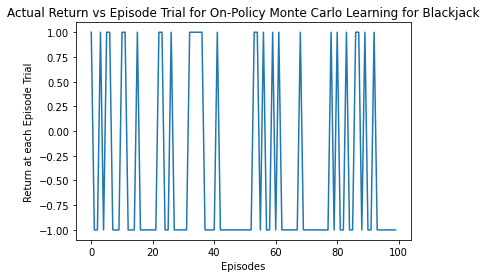

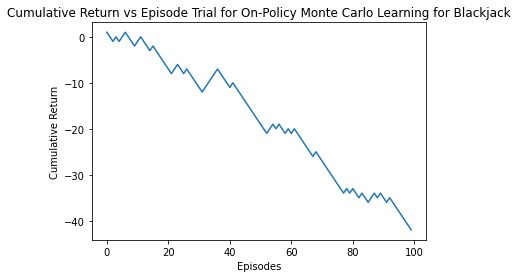

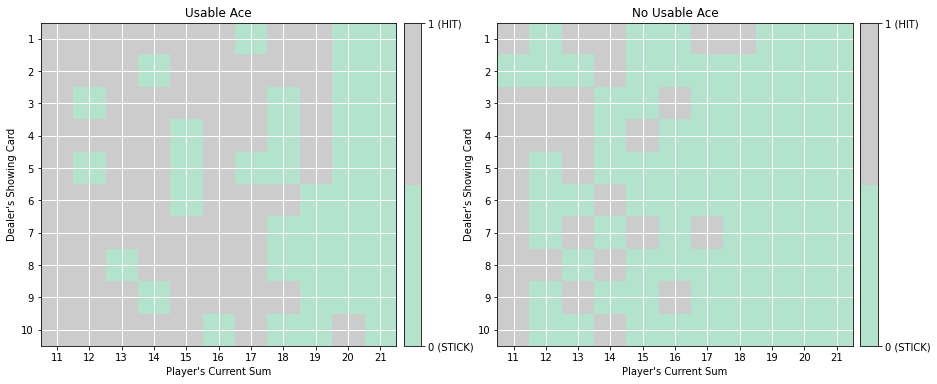

In [6]:
#FOR OFF-POLICY
print("Off-Policy MC Learning Policy:")
#Return and Cumulative Returns vs Episodes plots
n_episodes=100
returns_vs_eps_plot(n_episodes,Q_off_Pol,title='On-Policy')

#Policy Plots
pol_test = {key: np.argmax(off_MC_Learned_Policy(key)) for key in Q_off_Pol.keys()}
# plot the policy
plot_policy(pol_test)

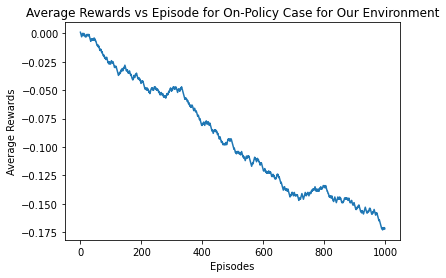

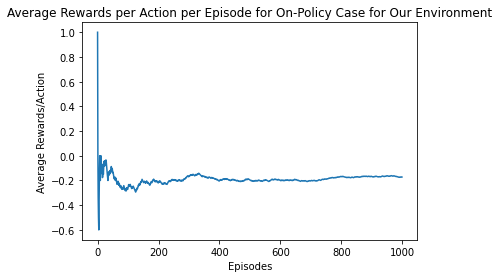

The Total Rewards for all 1000 episodes are:  -172.0
The Average Rewards for all 1000 episodes are:  -0.172


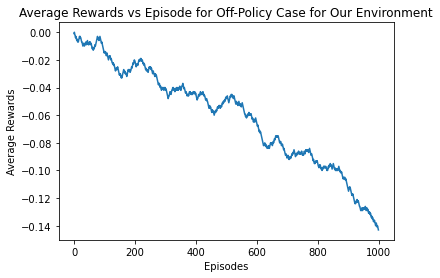

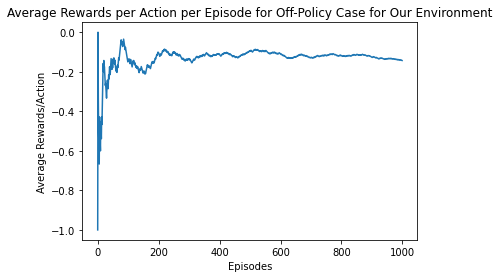

The Total Rewards for all 1000 episodes are:  -143.0
The Average Rewards for all 1000 episodes are:  -0.143


In [13]:
def play_episodes_on(environment, n_episodes, policy):
        count = 0
        total_reward = 0
        avg_rew=[]
        rew_per_cnt=[]
        for episode in range(n_episodes):
          terminated = False
          state = environment.reset()
          while not terminated:
            # Select best action to perform in a current state
            action = np.argmax(policy[state])
            # Perform an action an observe how environment acted in response
            next_state, reward, terminated, info = environment.step(action)
            # Summarize total reward
            count+=1
            
            total_reward += reward
            reward_per_count = total_reward/count
                                                
            # Update current state
            state = next_state
          
          avg_rew.append(total_reward/n_episodes) 
          rew_per_cnt.append(reward_per_count)          
                        
        average_reward = total_reward / n_episodes
        plt.plot(avg_rew)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards')
        plt.title('Average Rewards vs Episode for On-Policy Case for Our Environment')
        plt.show()
        plt.plot(rew_per_cnt)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards/Action')
        plt.title('Average Rewards per Action per Episode for On-Policy Case for Our Environment')
        plt.show()
        return total_reward, average_reward

def play_episodes_off(environment, n_episodes, policy):
        count = 0
        total_reward = 0
        avg_rew=[]
        rew_per_cnt=[]
        for episode in range(n_episodes):
          terminated = False
          state = environment.reset()
          while not terminated:
            # Select best action to perform in a current state
            action = np.argmax(policy[state])
            # Perform an action an observe how environment acted in response
            next_state, reward, terminated, info = environment.step(action)
            # Summarize total reward
            count+=1
            
            total_reward += reward
            reward_per_count = total_reward/count
                                                
            # Update current state
            state = next_state
          
          avg_rew.append(total_reward/n_episodes) 
          rew_per_cnt.append(reward_per_count)          
                        
        average_reward = total_reward / n_episodes
        plt.plot(avg_rew)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards')
        plt.title('Average Rewards vs Episode for Off-Policy Case for Our Environment')
        plt.show()
        plt.plot(rew_per_cnt)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards/Action')
        plt.title('Average Rewards per Action per Episode for Off-Policy Case for Our Environment')
        plt.show()
        return total_reward, average_reward

# Number of episodes. We keep it to 1000 as per the question
n_episodes = 1000

# Call the chosen environment
#environment = Univ_Camp_Bus()

#FOR ON-POLICY
# Search for an optimal policy using value iteration
policy = policy #Policy for on-policy case
# Apply best policy to the real environment
total_reward, average_reward = play_episodes_on(env, n_episodes, policy)
print('The Total Rewards for all 1000 episodes are: ',total_reward)
print('The Average Rewards for all 1000 episodes are: ',average_reward)

#FOR OFF-POLICY
# Search for an optimal policy using value iteration
policy = pol_test
# Apply best policy to the real environment
total_reward, average_reward = play_episodes_off(env, n_episodes, policy)
print('The Total Rewards for all 1000 episodes are: ',total_reward)
print('The Average Rewards for all 1000 episodes are: ',average_reward)